### Most basic training example

Here we train on data simulated with a simple linear model of fluorescence dynamics.
We use a convolutional neural network to get a factorized estimation of the posterior. 

At the end of the notebook we also show how to perform supervised training.

This notebook can be run on a CPU or GPU.

In [1]:
import sys
import os
sys.path.append("engine/")
sys.path.append("funcs/")
sys.setrecursionlimit(10000)

import theano.gpuarray
theano.gpuarray.use('cuda2')

import theano
import theano.tensor as T
from theano import config
import numpy as np
import pickle
import copy
import time
from itertools import *
from tqdm import tqdm

from RecognitionModel import *
from VIMCO_alpha import *
from plot_funcs import *

from matplotlib import pyplot as plt
from matplotlib import gridspec
%matplotlib inline

Using cuDNN version 6021 on context None
Preallocating 10986/12207 Mb (0.900000) on cuda2
Mapped name None to device cuda2: GeForce GTX TITAN X (0000:04:00.0)


Simulate some data from a simple linear model:
    
    C_(t) = s_t + sigmoid(g) * C_(t-1)
    F_(t) = softplus(α) * C_(t) + softplus(σ)
    
Softplus and sigmoid functions are used to keep the parameters in the allowed range and avoid the training to crash.
We simulate 100 cells with parameters drawn randomly from a certain parameter range. For every cell we sample three traces with different spiking rates.

In [2]:
rng = np.random.RandomState(1)
lasagne.random.set_rng(rng)

n_cells = 100
timebins = 10000
fps = 60
fRate = [0.7,1.,1.2]
fProb = [f/fps for f in fRate]

traces_foopsi = []
spikes_foopsi = []

TrueParams_foopsi = []
InitParameters = {}

low = {"gamma": 2.75, "alpha": -1.25, "beta": -0.3, "sigma": 0.07}
high = {"gamma": 4.6, "alpha": -0.43, "beta": -0.3, "sigma": 0.15}

gen_model = FOOPSI(low)

for i in tqdm(range(n_cells)):
    
    InitParameters = {}
    for p in low:
        if low[p] < high[p]:
            InitParameters.update({p:rng.randint(1000*low[p],1000*high[p])/1000}) 
        else:
            InitParameters.update({p:low[p]})
    
    gen_model.set_params(InitParameters)
    sim_spikes = []
    for f in fProb:
        sim_spikes.append(rng.binomial(1, f, (timebins)))
        
    sim_spikes = np.array(sim_spikes).astype(config.floatX)
    sim_fluor = gen_model.genfunc(sim_spikes) + rng.normal(size=(sim_spikes.shape)) * InitParameters['sigma']
    traces_foopsi.append(copy.deepcopy(sim_fluor))
    spikes_foopsi.append(copy.deepcopy(sim_spikes))
    TrueParams_foopsi.append(copy.deepcopy(InitParameters))

100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


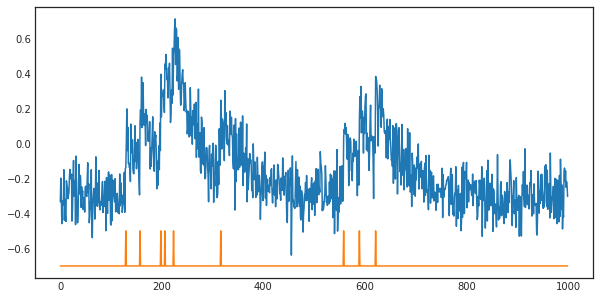

In [3]:
plt.figure(figsize = (10,5))
plt.plot(sim_fluor[0][:1000])
plt.plot(sim_spikes[0][:1000]/5-0.7)

Save dataset for later use.

In [4]:
data = {'traces': np.array(traces_foopsi).astype(config.floatX), 'spikes': np.array(spikes_foopsi).astype(config.floatX), 'params': TrueParams_foopsi, 'fps':[fps for _ in range(n_cells)], 'spike_fps':60}

with open('foopsi_100.pkl', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

Prepare data for training: we use 50 cells, and chop the traces into snippets with a length of 300 timesteps.
train_spikes is empty because we perform unsupervised learning.

In [5]:
timebins = 300

with open('foopsi_100.pkl', 'rb') as f:
    data = pickle.load(f)

n_cells = 30

Traces_train = data['traces']
Spikes_train = data['spikes']
truths = data['params']

train_traces, train_spikes = data_chop(timebins, Traces_train[:n_cells], Spikes_train[:n_cells], sv_inds = [])

print(train_traces[0].shape)
print(train_spikes)

(198, 300)
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


Initialize the model

In [6]:
init_params = {'gamma': 3.5, 'alpha': 0, 'beta': -0.3, 'sigma': -2.5}
inf_params = None

# Initialize recognition model network (1D CNN)
recDict = set_rec_net(num_filters=[30,25,25,20,15], filtsize=[31,21,21,13,11])
# Initialize model including recognition and generative model
model = VIMCO(init_params, inf_params, FOOPSI, recDict, BernoulliRecognition, batch_size=20, n_samples = 64, n_cells = n_cells, rng = rng, filename = 'foopsi_model')

model.true_params = [t for t in truths] # List of true parametervalues used to simulate data. Used to verify quality of generative model fit
model.gen_lr_fac = 30 # We mulitply the learning rate by this parameter for adjusting the generative model parameters. 
model.lr_decay = np.array(0.995, dtype=theano.config.floatX) # Learning rate decay (after every evaluation)
model.buffers = [100,50] # Buffer regions at the beginning and end of every trace. These are excluded when obtaining gradients.
model.facs = [1] # Downsample predictions and ground truth by that factor before evaluation. Useful to compare performance with other methods.
model.mrec.pz = 0.015 # Prior on the firing rate. This prior is rather 'weak' and doesn't influence training to much. initialization of gen. parameters has a much bigger impact. 
model.gradnorm_tot = True # Whether gradients are clipped when their norm exceeds a certain threshold. This proved to be important for good performance.
model.gradnorm_clip = 0.02 # Threshold value for clipping
model.validation_score = 'synchro_0' # During training the current as well as the best model are stored. The best model is determined by this metric.
# model.conc_cache = True

# Provide dataset for evaluation during training. Here we include ground truth spikes. We evaluate the first 'eval_T' tiemsteps of every trace provided.
# 'eval_rep' determines the number of samples taken for evaluation, multiple samples are only needed for correlated posteriors. 
# 'test_gen' determines wheter we calculate the quality of the reconstruction
# Multiple dicts can be provided to test on training and validation data.
model.eval_sets = [{'traces':Traces_train[:n_cells,:,:1000], 'spikes':Spikes_train[:n_cells,:,:1000], 'eval_T':1000, 'eval_rep': 1, 'test_gen':True}]

### Training:
'epochs' are not passes through the whole dataset but number of evaluations that come after every 'print_freq' iterations. So here we train for 500*100 = 50000 iterations. 

The following metrics are displayed during training, all of them are calculated on the training set (because we can only evaluate the gen. model fit on these cells). The method has proven to be very robust to overfitting though.
    * Corr. Train: Correlation of the predictions with the true spike train.
    * Synchro: Spike synchronization: http://www.scholarpedia.org/article/Measures_of_spike_train_synchrony#SPIKE_synchronization
            Unlike the correlation this metric operates on predicted spike trains and not firing rates. Therefore it is specifically valuable when comparing the performance of correlated and factorized posterior estimates.
            It takes values between 0 and 1 (higher is better)
    * MSE Pred./Truth. : Mean squared error of the reconstruction, divided by the best possible reconstruction (i.e. for true spikes and gen. model parameters, limited by the noise), so that the optimal value is 1.
                       Reconstruction is either based on the prediction (testing the quality of both the recogntion model and generative model fit) or on the true spike train (just testing the generative model fit)
    * Cost: Objective that gets optimized. Not a good measurement of perfance.
    * Factor: Number of inferred spikes / number of true spikes. This is usefull to see whether the generative model has roughly the right amplitude. For bad initialization training might diverge to a solution with small amplitudes and many spikes that fit the noise.
    * Time upd./Eval: Time required per training iteration / per evaluation

In [7]:
model.fit(train_traces,train_spikes, max_epochs = 250, learning_rate = 1e-3, print_output = True, print_freq = 200)

/usr/local/lib/python3.5/dist-packages/theano/tensor/basic.py:5262: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


Corr. Train: 0.748 Synchro: 0.670 || MSE Pred./Truth: 2.195 2.179 || Cost: -5.284 || Factor: 0.805 || Time upd./Eval.: 69.8 ms 2.1 s || BatchNr.: 200
Corr. Train: 0.753 Synchro: 0.672 || MSE Pred./Truth: 1.981 1.732 || Cost: 0.545 || Factor: 0.842 || Time upd./Eval.: 73.4 ms 1.5 s || BatchNr.: 400
Corr. Train: 0.767 Synchro: 0.681 || MSE Pred./Truth: 1.870 1.442 || Cost: 1.266 || Factor: 0.866 || Time upd./Eval.: 72.3 ms 1.6 s || BatchNr.: 600
Corr. Train: 0.813 Synchro: 0.779 || MSE Pred./Truth: 1.591 1.286 || Cost: 1.420 || Factor: 0.826 || Time upd./Eval.: 66.6 ms 1.7 s || BatchNr.: 800
Corr. Train: 0.819 Synchro: 0.821 || MSE Pred./Truth: 1.487 1.184 || Cost: 1.630 || Factor: 1.001 || Time upd./Eval.: 68.9 ms 1.4 s || BatchNr.: 1000
Corr. Train: 0.820 Synchro: 0.804 || MSE Pred./Truth: 1.512 1.088 || Cost: 1.730 || Factor: 1.011 || Time upd./Eval.: 71.2 ms 1.2 s || BatchNr.: 1200
Corr. Train: 0.835 Synchro: 0.818 || MSE Pred./Truth: 1.524 1.078 || Cost: 1.616 || Factor: 0.991 || Ti

Corr. Train: 0.850 Synchro: 0.829 || MSE Pred./Truth: 1.449 1.016 || Cost: 1.856 || Factor: 1.091 || Time upd./Eval.: 63.4 ms 1.1 s || BatchNr.: 11200
Corr. Train: 0.846 Synchro: 0.832 || MSE Pred./Truth: 1.519 1.025 || Cost: 1.906 || Factor: 1.156 || Time upd./Eval.: 68.8 ms 1.1 s || BatchNr.: 11400
Corr. Train: 0.840 Synchro: 0.804 || MSE Pred./Truth: 1.626 1.018 || Cost: 1.875 || Factor: 1.201 || Time upd./Eval.: 65.8 ms 0.9 s || BatchNr.: 11600
Corr. Train: 0.841 Synchro: 0.837 || MSE Pred./Truth: 1.459 1.019 || Cost: 1.865 || Factor: 1.076 || Time upd./Eval.: 70.2 ms 1.0 s || BatchNr.: 11800
Corr. Train: 0.850 Synchro: 0.836 || MSE Pred./Truth: 1.499 1.015 || Cost: 1.885 || Factor: 1.061 || Time upd./Eval.: 65.2 ms 0.9 s || BatchNr.: 12000
Corr. Train: 0.850 Synchro: 0.863 || MSE Pred./Truth: 1.325 1.018 || Cost: 1.868 || Factor: 0.986 || Time upd./Eval.: 67.8 ms 1.0 s || BatchNr.: 12200
Corr. Train: 0.848 Synchro: 0.773 || MSE Pred./Truth: 1.706 1.019 || Cost: 1.857 || Factor: 1.

Corr. Train: 0.854 Synchro: 0.847 || MSE Pred./Truth: 1.418 1.015 || Cost: 1.912 || Factor: 1.131 || Time upd./Eval.: 66.6 ms 1.3 s || BatchNr.: 22200
Corr. Train: 0.857 Synchro: 0.844 || MSE Pred./Truth: 1.352 1.009 || Cost: 1.937 || Factor: 1.089 || Time upd./Eval.: 65.0 ms 1.2 s || BatchNr.: 22400
Corr. Train: 0.853 Synchro: 0.839 || MSE Pred./Truth: 1.414 1.017 || Cost: 1.920 || Factor: 1.121 || Time upd./Eval.: 64.9 ms 1.0 s || BatchNr.: 22600
Corr. Train: 0.855 Synchro: 0.813 || MSE Pred./Truth: 1.430 1.022 || Cost: 1.912 || Factor: 1.030 || Time upd./Eval.: 65.7 ms 1.0 s || BatchNr.: 22800
Corr. Train: 0.854 Synchro: 0.840 || MSE Pred./Truth: 1.437 1.023 || Cost: 1.806 || Factor: 1.058 || Time upd./Eval.: 67.1 ms 1.1 s || BatchNr.: 23000
Corr. Train: 0.857 Synchro: 0.836 || MSE Pred./Truth: 1.360 1.018 || Cost: 1.893 || Factor: 1.059 || Time upd./Eval.: 63.6 ms 1.1 s || BatchNr.: 23200
Corr. Train: 0.850 Synchro: 0.803 || MSE Pred./Truth: 1.499 1.010 || Cost: 1.937 || Factor: 1.

Corr. Train: 0.856 Synchro: 0.825 || MSE Pred./Truth: 1.416 1.006 || Cost: 1.988 || Factor: 1.060 || Time upd./Eval.: 66.8 ms 1.1 s || BatchNr.: 33200
Corr. Train: 0.856 Synchro: 0.846 || MSE Pred./Truth: 1.354 1.009 || Cost: 1.924 || Factor: 1.005 || Time upd./Eval.: 71.5 ms 1.0 s || BatchNr.: 33400
Corr. Train: 0.853 Synchro: 0.857 || MSE Pred./Truth: 1.342 1.010 || Cost: 1.953 || Factor: 1.038 || Time upd./Eval.: 75.1 ms 1.2 s || BatchNr.: 33600
Corr. Train: 0.857 Synchro: 0.849 || MSE Pred./Truth: 1.316 1.010 || Cost: 1.990 || Factor: 1.029 || Time upd./Eval.: 70.2 ms 1.1 s || BatchNr.: 33800
Corr. Train: 0.855 Synchro: 0.865 || MSE Pred./Truth: 1.317 1.010 || Cost: 1.954 || Factor: 1.035 || Time upd./Eval.: 69.7 ms 1.3 s || BatchNr.: 34000
Corr. Train: 0.853 Synchro: 0.837 || MSE Pred./Truth: 1.405 1.007 || Cost: 1.995 || Factor: 1.081 || Time upd./Eval.: 64.3 ms 1.0 s || BatchNr.: 34200
Corr. Train: 0.852 Synchro: 0.830 || MSE Pred./Truth: 1.513 1.015 || Cost: 1.869 || Factor: 1.

Corr. Train: 0.860 Synchro: 0.835 || MSE Pred./Truth: 1.367 1.005 || Cost: 1.890 || Factor: 1.054 || Time upd./Eval.: 71.1 ms 1.1 s || BatchNr.: 44200
Corr. Train: 0.857 Synchro: 0.844 || MSE Pred./Truth: 1.352 1.006 || Cost: 1.896 || Factor: 1.082 || Time upd./Eval.: 67.6 ms 1.1 s || BatchNr.: 44400
Corr. Train: 0.857 Synchro: 0.851 || MSE Pred./Truth: 1.330 1.008 || Cost: 1.888 || Factor: 1.022 || Time upd./Eval.: 63.9 ms 0.9 s || BatchNr.: 44600
Corr. Train: 0.859 Synchro: 0.838 || MSE Pred./Truth: 1.416 1.008 || Cost: 1.800 || Factor: 1.074 || Time upd./Eval.: 69.1 ms 1.0 s || BatchNr.: 44800
Corr. Train: 0.859 Synchro: 0.851 || MSE Pred./Truth: 1.324 1.008 || Cost: 1.948 || Factor: 1.024 || Time upd./Eval.: 70.5 ms 1.1 s || BatchNr.: 45000
Corr. Train: 0.858 Synchro: 0.836 || MSE Pred./Truth: 1.381 1.009 || Cost: 1.969 || Factor: 1.026 || Time upd./Eval.: 65.5 ms 1.0 s || BatchNr.: 45200
Corr. Train: 0.859 Synchro: 0.836 || MSE Pred./Truth: 1.362 1.007 || Cost: 1.973 || Factor: 1.

All metrics are stored in ordered dictionaries and can be plotted:

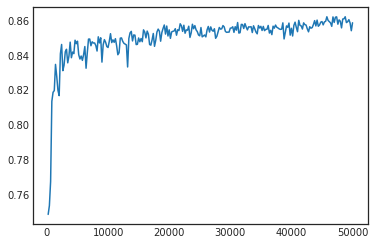

In [9]:
plot_od(model.col_dict['corr_0'])

Fit of generative model parameters for the 50 cells.
Red are true values, blue are inferred values, blue line is initialization.

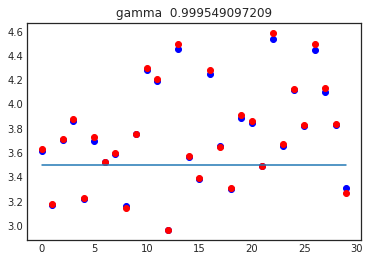

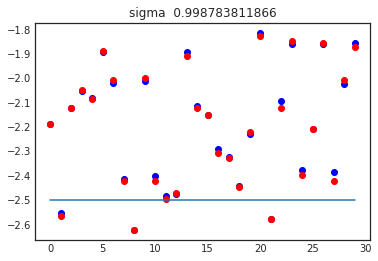

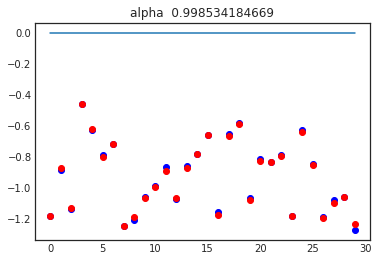

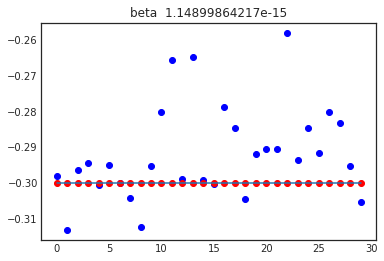

In [10]:
for p in init_params.keys():
    if p is not 'sigma':
        true = [np.array(truths[c][p]).max() for c in range(n_cells)]
    else:
        true =  [inv_softp(np.array(truths[c][p]).max()) for c in range(n_cells)]
    learned = [np.array(model.mgen.genparam_dicts[c][p]).max() for c in range(n_cells)]
    plt.figure()
    plt.plot(learned,'bo')
    plt.plot(true,'ro')
    plt.plot([0,n_cells-1],[init_params[p],init_params[p]])
    plt.title(p + '  ' + str(np.corrcoef(true,learned)[0,1]))
    plt.show()

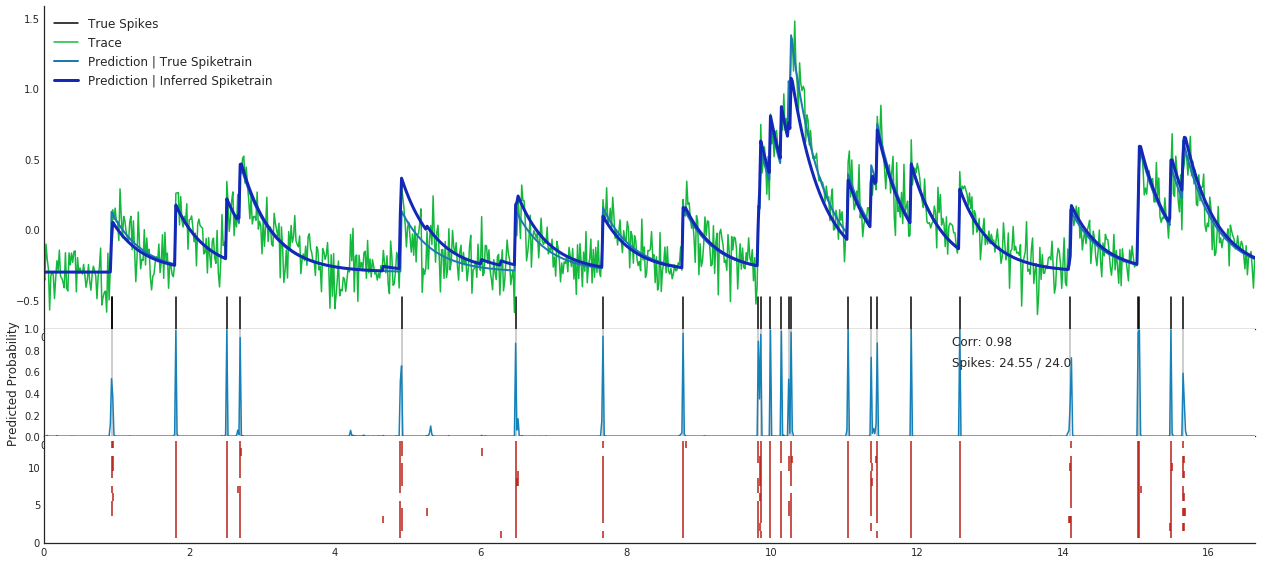

In [22]:
plot_preds_bl(model, data = data, cell = 4,trace =1, figsize = (25,8))

For supervised learning we the use the SV class and pass the ground truth spikes. We use two datasets for evaluation to check whether we overfit.

In [18]:
from SV_C import *
train_traces, train_spikes = data_chop(timebins, Traces_train[:n_cells], Spikes_train[:n_cells], sv_inds = np.arange(n_cells))

recDict = set_rec_net(num_filters=[30,25,25,20,15], filtsize=[31,21,21,13,11])
model = SV(recDict, BernoulliRecognition, batch_size=20, rng = rng, filename = None)

model.lr_decay = np.array(0.995, dtype=theano.config.floatX) 
model.buffers = [100,50]
model.facs = [1] 

model.eval_sets = [{'traces':Traces_train[:n_cells,:,:1000], 'spikes':Spikes_train[:n_cells,:,:1000], 'eval_T':1000, 'eval_rep': 1, 'test_gen':False}, {'traces':Traces_train[n_cells:100,:,:1000], 'spikes':Spikes_train[n_cells:100,:,:1000], 'eval_T':1000, 'eval_rep': 1, 'test_gen':False}]
model.fit(train_traces,train_spikes,max_epochs= 50, learning_rate = 1e-3, print_output=True, print_freq=100)

Corr. Train/Val: 0.817/0.837 || Cost: -5.352 || Factor: 1.000 || Time upd./Eval.: 6.5 ms 0.1 s || BatchNr.: 100
Corr. Train/Val: 0.836/0.854 || Cost: -2.851 || Factor: 1.016 || Time upd./Eval.: 6.4 ms 0.1 s || BatchNr.: 200
Corr. Train/Val: 0.841/0.860 || Cost: -2.630 || Factor: 1.112 || Time upd./Eval.: 6.5 ms 0.1 s || BatchNr.: 300
Corr. Train/Val: 0.840/0.857 || Cost: -2.414 || Factor: 1.190 || Time upd./Eval.: 5.5 ms 0.1 s || BatchNr.: 400
Corr. Train/Val: 0.851/0.859 || Cost: -2.437 || Factor: 1.123 || Time upd./Eval.: 5.6 ms 0.1 s || BatchNr.: 500
Corr. Train/Val: 0.853/0.866 || Cost: -2.491 || Factor: 1.044 || Time upd./Eval.: 6.4 ms 0.1 s || BatchNr.: 600
Corr. Train/Val: 0.850/0.870 || Cost: -2.428 || Factor: 0.922 || Time upd./Eval.: 5.7 ms 0.1 s || BatchNr.: 700
Corr. Train/Val: 0.849/0.869 || Cost: -2.194 || Factor: 0.970 || Time upd./Eval.: 6.7 ms 0.1 s || BatchNr.: 800
Corr. Train/Val: 0.855/0.871 || Cost: -2.573 || Factor: 1.046 || Time upd./Eval.: 6.0 ms 0.1 s || BatchN